In [288]:
# Importing Librarie
import numpy as np
import pandas as pd
import os
import os.path
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.layers import Dense,Dropout,BatchNormalization, ReLU,Softmax
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from PIL import Image
from io import BytesIO
import seaborn as sns
from numpy.core.fromnumeric import squeeze
import warnings
warnings.filterwarnings('ignore')

In [17]:
guns = Path('/content/drive/MyDrive/Colab Notebooks/HandGun Detection/Weapons')
cellphone = Path('/content/drive/MyDrive/Colab Notebooks/HandGun Detection/cellphone')

In [18]:
#It is a Gun label 1
gunpaths = list(guns.glob(r'*.jpg'))
gunpaths = [gunpaths[x] for x in range(850)]
gunlabels = []
for i in gunpaths:
    gunlabels.append(1)

#Not a Gun label 0
celllabels = []
cellpaths = list(cellphone.glob(r'*.jpg'))
for i in cellpaths:
    celllabels.append(0)

gunpaths = pd.Series(gunpaths, name = "Filepath").astype(str)
gunlabels = pd.Series(gunlabels, name = "Label").astype(str)

cellpaths = pd.Series(cellpaths, name = "Filepath").astype(str)
celllabels = pd.Series(celllabels, name = "Label").astype(str)

s1 = pd.concat([gunpaths, gunlabels], axis = 1)
s2 = pd.concat([cellpaths, celllabels], axis = 1)
image_df = s1.append(s2, ignore_index=True)

In [22]:
image_df.sample(5)

,Filepath,Label
570,/content/drive/MyDrive/Colab Notebooks/HandGun...,1
256,/content/drive/MyDrive/Colab Notebooks/HandGun...,1
726,/content/drive/MyDrive/Colab Notebooks/HandGun...,1
53,/content/drive/MyDrive/Colab Notebooks/HandGun...,1
951,/content/drive/MyDrive/Colab Notebooks/HandGun...,0


In [23]:
# pd.set_option('display.max_rows', 50)
print(image_df.size)
image_df.shape

2136


(1068, 2)

In [24]:
x = []
y = []
for path, label in image_df.values:
  a = Image.open(path).convert(mode="L")
  a = a.resize((224,224))
  a = np.array(a).astype('float32')/255
  x.append(a)
  y.append(label)

train_data, test_data, train_label, test_label = train_test_split(x, y, test_size=0.25, random_state=1)

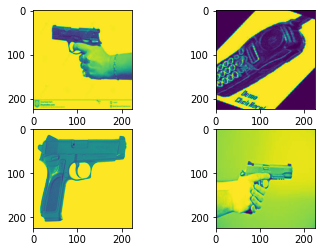

In [43]:
# plotting sample 4 images
plt.subplot(221)
plt.imshow(train_data[101])
plt.subplot(222)
plt.imshow(train_data[5])
plt.subplot(223)
plt.imshow(train_data[26])
plt.subplot(224)
plt.imshow(train_data[16])

# show the plot
plt.show()

In [44]:

train_df, test_df = train_test_split(image_df, train_size=0.80, shuffle=True, random_state=1)

In [48]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255,
)

In [49]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 684 validated image filenames belonging to 2 classes.
Found 170 validated image filenames belonging to 2 classes.
Found 214 validated image filenames belonging to 2 classes.


In [50]:

# Using Sequential model
model = models.Sequential()

#1st Layer with kernel size 3*3 with pool size of 2*2 and ReLU as activation function for 28*28 shape input img
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))

#2n Layer with kernel size 3*3 with pool size of 2*2 and ReLu as activation function for 28*28 shape input img
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#3rd Layer with kernel size 3*3 with pool size of 2*2 and ReLu as activation function for 28*28 shape input img
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#4th Layer with kernel size 3*3 with pool size of 2*2 and ReLu as activation function for 28*28 shape input img
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


#5th Layer with kernel size 3*3 with pool size of 2*2 and ReLu as activation function for 28*28 shape input img
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#Flattening the inputs
model.add(layers.Flatten())

#Densely connected NN
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 26, 26, 128)     

In [51]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_images,
    validation_data = val_images,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/5
22/22 [==============================] - 100s 5s/step - loss: 0.6306 - accuracy: 0.7968 - val_loss: 0.5268 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 2/5
22/22 [==============================] - 95s 4s/step - loss: 0.3753 - accuracy: 0.8289 - val_loss: 0.1980 - val_accuracy: 0.9294 - lr: 0.0010
Epoch 3/5
22/22 [==============================] - 95s 4s/step - loss: 0.1587 - accuracy: 0.9298 - val_loss: 0.0985 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 4/5
22/22 [==============================] - 95s 4s/step - loss: 0.1104 - accuracy: 0.9488 - val_loss: 0.1510 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 5/5
22/22 [==============================] - 95s 4s/step - loss: 0.1131 - accuracy: 0.9503 - val_loss: 0.1562 - val_accuracy: 0.9176 - lr: 0.0010


In [53]:
results = model.evaluate(test_images)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1]*100))

7/7 [==============================] - 8s 1s/step - loss: 0.1287 - accuracy: 0.9486
Test Loss: 0.12873
Test Accuracy: 94.86%


In [54]:
#Visualize the model evaluation scheme
def my_plot(history):
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
    
  ax1.plot(history.history['accuracy'], label='Training Accuracy', color='green')
  ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
    
  ax2.plot(history.history['loss'], label = 'Training Loss', color='orange')
  ax2.plot(history.history['val_loss'], label = 'Validation Loss', color='red')
  
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy', color='g')
  ax2.set_ylabel('Loss', color='b')
    
  ax1.legend(loc=1)  
  ax2.legend(loc=3)
  # plt.ylim([0.6, 2.5])
  plt.title('Training-Validation Loss and Accuracy')
  plt.show()

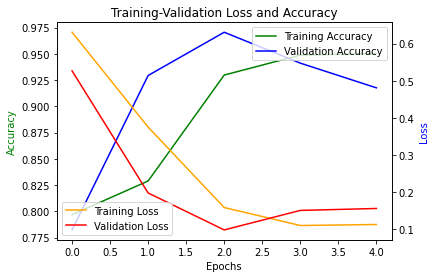

In [55]:
my_plot(history)

In [63]:
pred = (model.predict(test_images) >= 0.5).astype(np.int)

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


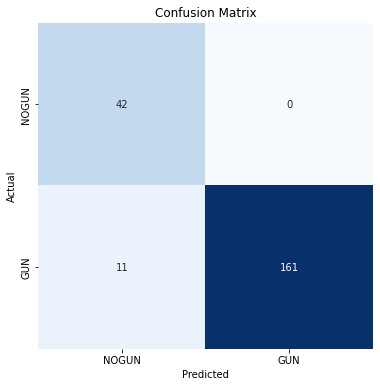




Classification Report:
--------------------------
               precision    recall  f1-score   support

       NOGUN       0.79      1.00      0.88        42
         GUN       1.00      0.94      0.97       172

    accuracy                           0.95       214
   macro avg       0.90      0.97      0.93       214
weighted avg       0.96      0.95      0.95       214



In [71]:
cm = confusion_matrix(test_images.labels, pred, labels=[0, 1])
clr = classification_report(test_images.labels, pred, labels=[0, 1], target_names=["NOGUN", "GUN"])

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5,1.5], labels = ["NOGUN", "GUN"])
plt.yticks(ticks=[0.5,1.5], labels = ["NOGUN", "GUN"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\n\n")
print("Classification Report:\n--------------------------\n", clr)

In [94]:
y_pred=[]
y_true=[]
for i in pred:
  y_pred+=[i]
for i in test_df['Label']:
  y_true+=i

PRED=np.array(y_pred,dtype=int)
ANS=np.array(y_true,dtype=int)
print(PRED[10:20])
print(ANS[10:20])

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]]
[1 1 1 1 1 1 1 1 0 1]


In [95]:
print('Accuracy : ',accuracy_score(ANS,PRED))

Accuracy :  0.9485981308411215


In [100]:
model.save("gun_model.h5")

In [278]:
def plot_image(path=None,url=None):
  if url:
    r= requests.get(url)
    with BytesIO(r.content) as f:
      img = Image.open(f).convert(mode="L")
  else:
      img = Image.open(path).convert(mode="L")
  img = img.resize((224,224))
  test_img = np.array(img)
  test_img = test_img.astype('float32') / 255
  x = (255 - np.expand_dims(np.array(test_img), -1))/255
  return x

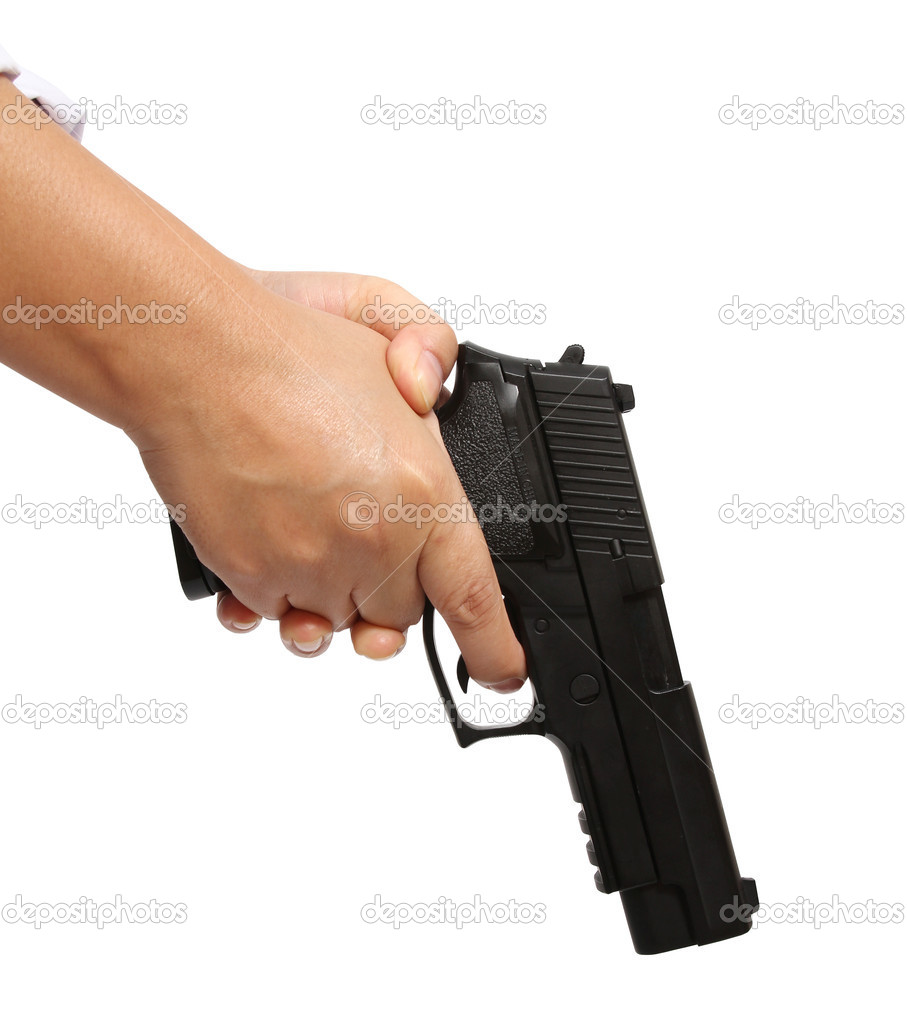

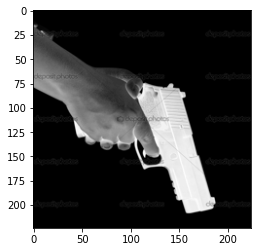

In [258]:
url = "https://github.com/sanketsanap5/Handgun-Detection/blob/main/Weapons/armas%20(445).jpg?raw=true"
img = plot_image(url = url)
plt.imshow(img.squeeze(-1),cmap='gray')

In [275]:
img_array = keras.preprocessing.image.img_to_array(img.squeeze(-1))
pred_img = model.predict(np.expand_dims(img_array, axis=0))
print(pred_img*100)

[[98.42453]]


In [276]:
from skimage import transform
def load(filename):
   np_image = Image.open(filename).convert(mode="L")
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

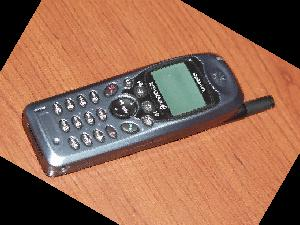

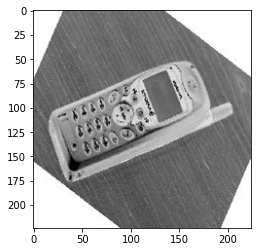

In [282]:
path = "/content/drive/MyDrive/Colab Notebooks/HandGun Detection/image_0002.jpg"
img = plot_image(path = path)
plt.imshow(img.squeeze(-1),cmap='gray')

In [286]:
image = load(path)

In [287]:
pred_img = model.predict(image)
print(pred_img*100)

[[15.198609]]
